In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Installing Libraries

In [ ]:
!pip install chart_studio

In [ ]:
!pip install tensorflow==1.15
!pip install "tensorflow_hub>=0.6.0" 

In [ ]:
## checking if GPU is working fine or not

import tensorflow as tf
tf.test.is_gpu_available()

True

In [ ]:
#importing the libraries
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import os
import re
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import itertools
from scipy import stats
from ast import literal_eval
import spacy

In [ ]:
import gensim
import json
import pickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import keras.utils
from nltk.tokenize import sent_tokenize
from keras import utils as np_utils

#Keras Tokenizer just replaces certain punctuation characters and splits on the remaining space character.
#NLTK Tokenizer uses the Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank. 

In [ ]:
#WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

In [ ]:
#converting the transcript files into a dataframe
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all.csv', sep=',')
    print("File was created")
    return all_participants

In [ ]:
#loading the data
data_path = "/content/drive/My Drive/transcripts/"
all_participants = transcripts_to_dataframe(data_path)

File was created


In [ ]:
all_participants.head(20)

,personId,question,answer
0,300,hi i'm ellie thanks for coming in today,
1,300,i was created to talk to people in a safe and ...,
2,300,think of me as a friend i don't judge i can't ...,
3,300,i'm here to learn about people and would love ...,
4,300,i'll ask a few questions to get us started and...,
5,300,how are you doing today,good
6,300,that's good,
7,300,where are you from originally,atlanta georgia
8,300,really,
9,300,why'd you move to l_a,um my parents are from here um


In [ ]:
#Selecting the data from the data from based on the questions asked  ['where', 'when', 'how', 'why', 'are', 'what', 'do', 'have', 'can', 'did', 'is', 'could', 'so', 'tell', 'who', 'has']
interrogative = ["where", "when", "how","why","are","what","do","have","can","did","is", "could", "so", "tell", "who", "has"]
rslt_df = all_participants[all_participants.question.str.contains('|'.join(interrogative),na=False)]
rslt_df['answer'].replace('', np.nan, inplace=True)
rslt_df.dropna(subset = ["answer"], inplace=True)
rslt_df.reset_index(drop=True, inplace=True)
rslt_df
#rslt_df = rslt_df.to_csv("/content/drive/My Drive/rslt_df.csv")

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6746: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,personId,question,answer
0,300,how are you doing today,good
1,300,where are you from originally,atlanta georgia
2,300,why'd you move to l_a,um my parents are from here um
3,300,how do you like l_a,i love it
4,300,what are some things you really like about l_a,i like the weather i like the opportunities u...
...,...,...,...
8698,390,that's so good to hear,mm
8699,390,is there anything you regret,um hm no um except meeting that one woman uh
8700,390,what advice would you give to yourself ten or ...,uh i don't know probably try a little harder ...
8701,390,tell me how you spend your ideal weekend,oh um getting out of town um going going away...


In [ ]:
rslt_df.sample(10)

,personId,question,answer
1347,328,who's someone that's been a positive influence...,scrubbed_entry and that's what i wanna do i d...
4380,409,what advice would you give to yourself ten or ...,well i'd say to really you know analyze kinda...
6468,443,what are some things that usually put you in a...,music comedies
1498,329,how easy is it for you to get a good night's s...,um pretty easy uh i don't sleep as well as i ...
5906,430,what's something you feel guilty about,the same girl that i broke up with she was th...
2710,359,how easy was it for you to get used to living ...,very easy very easy just like you know you ca...
8201,365,what's something you feel guilty about,something i feel guilty about is uh not talki...
5742,423,have you been diagnosed with depression,um i think through finding p_t_s_d they were ...
1343,328,have you noticed any changes in your behavior ...,no no no changes no
8222,365,what advice would you give to yourself ten or ...,um it's okay to be selfish it's okay to you k...


In [ ]:
rslt_df['question']= rslt_df.apply(lambda row: "{0}?".format(row.question), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rslt_df

,personId,question,answer,statements
0,300,how are you doing today?,good,how are you doing today?: good
1,300,where are you from originally?,atlanta georgia,where are you from originally?: atlanta georgia
2,300,why'd you move to l_a?,um my parents are from here um,why'd you move to l_a?: um my parents are from...
3,300,how do you like l_a?,i love it,how do you like l_a?: i love it
4,300,what are some things you really like about l_a?,i like the weather i like the opportunities u...,what are some things you really like about l_a...
...,...,...,...,...
8698,390,that's so good to hear?,mm,that's so good to hear?: mm
8699,390,is there anything you regret?,um hm no um except meeting that one woman uh,is there anything you regret?: um hm no um exc...
8700,390,what advice would you give to yourself ten or ...,uh i don't know probably try a little harder ...,what advice would you give to yourself ten or ...
8701,390,tell me how you spend your ideal weekend?,oh um getting out of town um going going away...,tell me how you spend your ideal weekend?: oh ...


In [ ]:
from nltk.tokenize import sent_tokenize
rslt_df['answer'] = rslt['answer']

In [ ]:
#rslt_df['statements'] = rslt_df[['question', 'answer']].agg(':'.join, axis=1)
#rslt_df

In [ ]:
def load_avec_dataset_file(path,score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])  #cut function used to segregate array into bins 5 levels - 'none','mild','moderate','moderately severe', 'severe'
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist() #categorical levels 
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": int, "level": int, 'PHQ8_Score': int})
    return ds

In [ ]:
train = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/train_split_Depression_AVEC2017 (1).csv','PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/dev_split_Depression_AVEC2017.csv','PHQ8_Score')
test = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/full_test_split.csv','PHQ8_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


In [ ]:
ds_total = pd.concat([train,dev,test],sort=True)
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [ ]:
ds_total

,PHQ8_Score,Participant_ID,cat_level,level
0,0,303,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,6,304,"[0.0, 0.0, 1.0, 0.0, 0.0]",2
2,7,305,"[0.0, 0.0, 1.0, 0.0, 0.0]",2
3,4,310,"[0.0, 1.0, 0.0, 0.0, 0.0]",1
4,2,312,"[0.0, 1.0, 0.0, 0.0, 0.0]",1
...,...,...,...,...
42,0,467,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
43,3,469,"[0.0, 1.0, 0.0, 0.0, 0.0]",1
44,3,470,"[0.0, 1.0, 0.0, 0.0, 0.0]",1
45,1,480,"[0.0, 1.0, 0.0, 0.0, 0.0]",1


In [ ]:
len(ds_total)

189

In [ ]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [ ]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


In [ ]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])
ds_total_b

,PHQ8_Score,Participant_ID,cat_level,level
0,0,303,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
41,0,363,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
42,0,364,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
43,0,366,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
45,0,369,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
...,...,...,...,...
9,18,332,"[0.0, 0.0, 0.0, 0.0, 1.0]",4
13,18,354,"[0.0, 0.0, 0.0, 0.0, 1.0]",4
23,17,405,"[0.0, 0.0, 0.0, 0.0, 1.0]",4
37,17,453,"[0.0, 0.0, 0.0, 0.0, 1.0]",4


In [ ]:
len(ds_total_b)

124

In [ ]:
ds_lp = ds_total.merge(rslt_df,left_on=ds_total.Participant_ID.astype(int), right_on=rslt_df.personId.astype(int))
ds_lp_b = ds_total_b.merge(rslt_df,left_on=ds_total_b.Participant_ID.astype(int).astype(int), right_on=rslt_df.personId.astype(int))
len(ds_lp)

8703

In [ ]:
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

In [ ]:
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

In [ ]:
data_df = pd.concat([ds_lp['level'], ds_lp['answer']], axis=1)
data_df

,level,answer
0,0,okay how 'bout yourself
1,0,here in california
2,0,oh well that it's big and broad there's a lot...
3,0,traffic um maybe the violence rate bad news e...
4,0,sociology i have a um two year degree in libe...
...,...,...
8698,2,um yesterday i was watching a movie with my g...
8699,2,um very honest um sometimes brutally so but i...
8700,2,um i guess well it's what i'm working on whic...
8701,2,it gets better <sigh> um stay in shape it get...


In [ ]:
train_df = pd.concat([train_lp['level'], train_lp['answer']], axis=1)
dev_df = pd.concat([dev_lp['level'], dev_lp['answer']], axis=1)
test_df = pd.concat([test_lp['level'], test_lp['answer']], axis=1)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Converting sentences in ELMO vectors

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

train_y = list(train_df['level'])
train_x = list(train_df['answer'])

dev_y = list(dev_df['level'])
dev_x = list(dev_df['answer'])

test_y = list(test_df['level'])
test_x = list(test_df['answer'])

#y = list(data_df['level'])
#x = list(data_df['answer'])



le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)


#x_enc = x
#y_enc = encode(le, y)
train_enc = encode(le,train_y)
dev_enc = encode(le,dev_y)
test_enc = encode(le,test_y)

In [ ]:
y_enc.shape

(8703, 5)

In [ ]:
x_enc

[" okay how 'bout yourself",
 ' here in california',
 " oh well that it's big and broad there's a lot to do a lot of um um job opportunities than other states um pretty much that it's big and there's a lot you can do here",
 " traffic um maybe the violence rate bad news even though you know you wanna know what's going on in your environment but you still have to watch it so you can you know look out to see what's going on on a daily basis",
 ' sociology i have a um two year degree in liberal arts but my major was sociology',
 " no i'm actually an m_t_a bus operator",
 " well since metro is steady growing um my dream job is to move up in the company and i'm about to actually start some classes for supervisory next week so um 'cause they look to promote within the company so that's the good thing there's a lot of opportunities at metro where you can take classes and they'll pay for your tuition and things of that nature",
 ' thanks',
 " well it's not actually hard as right now it's easy 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.asarray(x_enc), y_enc, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(6962, 5)

In [ ]:
x_train.shape

(6962,)

In [ ]:
from keras.layers import Input, Lambda, Dense,Bidirectional,LSTM,Dropout
from keras.models import Model
import keras.backend as K

def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(5, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 263,685
Trainable params: 263,685
Non-trainable params: 0
_________________________________________________________________


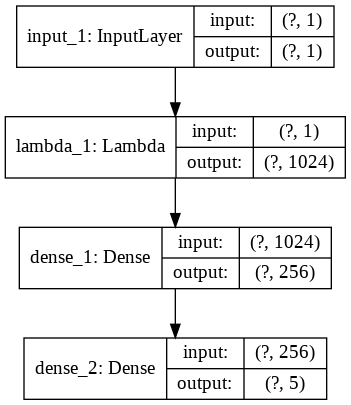

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=5, batch_size=8)
    model.save_weights('./elmo-model.h5')

Epoch 1/5
6962/6962 [==============================] - 154s 22ms/step - loss: 1.7456 - accuracy: 0.3387
Epoch 2/5
6962/6962 [==============================] - 152s 22ms/step - loss: 1.5170 - accuracy: 0.3604
Epoch 3/5
6962/6962 [==============================] - 151s 22ms/step - loss: 1.5013 - accuracy: 0.3699
Epoch 4/5
6544/6962 [===========================>..] - ETA: 9s - loss: 1.4838 - accuracy: 0.3785

KeyboardInterrupt: ignored

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=16)

In [ ]:
from sklearn import metrics
# decode test labels
y_test = decode(le, y_test)
# decode predicted labels
y_preds = decode(le, predicts)

AxisError: ignored

In [ ]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       223
           1       0.34      0.98      0.51       596
           2       0.37      0.03      0.05       427
           3       0.00      0.00      0.00       255
           4       1.00      0.00      0.01       240

    accuracy                           0.34      1741
   macro avg       0.34      0.20      0.11      1741
weighted avg       0.35      0.34      0.19      1741



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



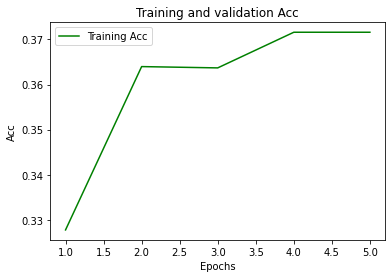

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()


In [ ]:
new_text =  ['I feel helpless'
            ]
#the texts should go through clean text also
new_text_pr = np.array(new_text, dtype=object)[:, np.newaxis]

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')
    import time
    t = time.time()
    predicts = model.predict(new_text_pr)
    print("time: ", time.time() - t)
    print(predicts)

InvalidArgumentError: ignored